In [87]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pandas_profiling import ProfileReport
import scipy.stats as stats

In [4]:
data = pd.read_csv('forest_fires_dataset.csv')

In [7]:
data

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51.0,6.7,0.0,0.00
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33.0,0.9,0.0,0.00
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33.0,1.3,0.0,0.00
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97.0,4.0,0.2,0.00
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99.0,1.8,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,4,3,aug,sun,81.6,56.7,665.6,1.9,27.8,32.0,2.7,0.0,6.44
513,2,4,aug,sun,81.6,56.7,665.6,1.9,21.9,71.0,5.8,0.0,54.29
514,7,4,aug,sun,81.6,56.7,665.6,1.9,21.2,70.0,6.7,0.0,11.16
515,1,4,aug,sat,94.4,146.0,614.7,11.3,25.6,42.0,4.0,0.0,0.00


In [6]:
data.describe()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,4.669246,4.299807,90.644681,110.872340,547.940039,9.021663,18.889168,44.288201,4.017602,0.021663,12.847292
std,2.313778,1.229900,5.520111,64.046482,248.066192,4.559477,5.806625,16.317469,1.791653,0.295959,63.655818
min,1.000000,2.000000,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,0.000000
25%,3.000000,4.000000,90.200000,68.600000,437.700000,6.500000,15.500000,33.000000,2.700000,0.000000,0.000000
50%,4.000000,4.000000,91.600000,108.300000,664.200000,8.400000,19.300000,42.000000,4.000000,0.000000,0.520000
75%,7.000000,5.000000,92.900000,142.400000,713.900000,10.800000,22.800000,53.000000,4.900000,0.000000,6.570000
max,9.000000,9.000000,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000,1090.840000


In [13]:
report = ProfileReport(data)

In [15]:
report.to_file("report.html")

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 32.09it/s]


 # Użyteczność `ProfileReport`

Wygenerowany przez bibliotekę raport jest bardzo przydatny. Można w nim znaleźć histogram rozkładu próbkowego każdej zmiennej razem z ich statystykami opisowymi. Bez problemu można porównać zmienne ze sobą na wykresie typu scatter. Oczywistym problemem takiego wykresu (bez możliwości dorysowania KDE), jest brak widoczności gęstości - w tym zbiorze przykładowo nic nie można wyczytać ze scatterplota `X~temp`. Przydatna byłaby też możliwość pokazywania pojedyńczych rozkładów zmiennych oraz dodawania linii regresji na wykresach z `Interactions`

Część `Correlations` też jest całkiem przydatna, bo oszczędza pisania własnej heatmapy przy wykonywaniu każdej EDA  

W całym narzędziu całkiem brakuje możliwości dodania modyfikatorów (`log`,`exp`) do cech.

# Macierz korelacji

<AxesSubplot:>

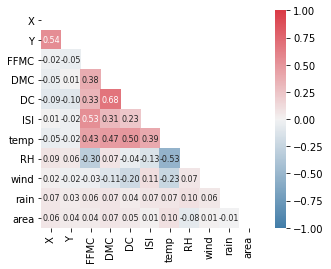

In [60]:
corr = data.corr()
mask = np.triu(np.ones_like(corr,dtype=bool))
sns.heatmap(corr,mask=mask,
    vmax=1,
    vmin=-1,
    fmt='.2f',
    annot_kws={"fontsize":8},
    square=True,
    cmap=sns.diverging_palette(240, 10,as_cmap=True),
    annot=True
)

Widać sporo korelacji zmiennych należących do grupy wskaźników `FMI`, ale to całkiem oczekiwane - wskaźniki te zostały stworzone żeby pokazywać ryzyko ognia oraz wszystkie bazowo używają podobnych zmiennych. Widać to na poniższym wykresie opisującym wszystkie zmienne z tej kategorii

![](fwi.png)

Całkiem intuicyjne jest też powiązanie temperatury z wilgotnością w powietrzu

<AxesSubplot:xlabel='RH', ylabel='temp'>

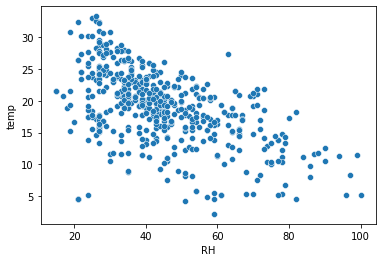

In [47]:
sns.scatterplot(y=data.temp,x=data.RH)


Widać coś na styl zależności potęgowej - z fizycznej intuicji wiemy że większa temperatura powinna powodować większą *zmianę* wilgotności, co ten wykres odzwierciedla

(-0.4777914471630657, 7.656020878514516e-31)


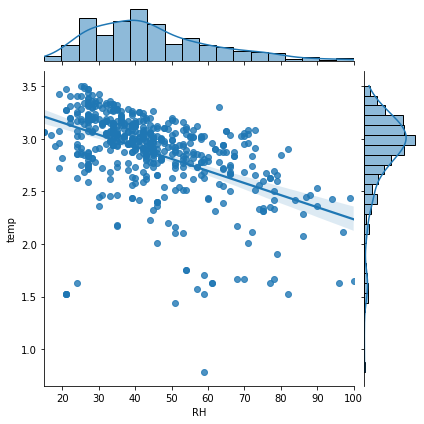

In [70]:
print(stats.pearsonr(np.log(data.temp),data.RH))
sns.jointplot(kind='reg',
    y=np.log(data.temp),
    x=data.RH,
    )


I rzeczywiście - większa temperatura zazwyczaj oznacza mniejszą wilgotność

Tak jak można by się było spodziewać - rozkład temperatur w których występują pożary jest trochę wyższy (pod względem temperatur) niż zwykły rozkład temperatur dla regionu

[-0.3302106140354586, -0.5212849866294275]


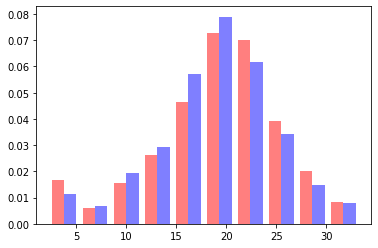

In [92]:
burning = data[data.area > 0]
plt.hist([burning.temp,data.temp],color=['r','b'],alpha=0.5,density=True)
print([stats.skew(s) for s in [data.temp, burning.temp]])